In [1]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
np.set_printoptions(precision=4)

In [2]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [3]:
#将每个字符编码为一个整数
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
#设置char_level=True，以得到字符级别的编码，而不是默认的单词级别的编码
tokenizer.fit_on_texts([shakespeare_text])

In [4]:
tokenizer.texts_to_sequences(["Fuck"])

[[20, 14, 19, 25]]

In [5]:
tokenizer.sequences_to_texts([[20, 14, 19, 25]])

['f u c k']

## 将序列数据集切分成多个窗口

In [6]:
#对完整文本做编码，将每个字符都用 ID 来表示（减 1 使 ID 从 0 到 38，而不是 1 到 39）
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

dataset_size=len(encoded)

In [7]:
#将前 90% 的文本作为训练集（剩下的作为验证集和测试集）
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])


In [8]:
#调用window()方法创建一个短文本窗口的数据集
#RNN 学不到任何长度超过n_steps的规律，所以n_steps不要太短
n_steps = 100
window_length = n_steps + 1 # target = input 向前移动 1 个字符
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

#为了获得可能的最大训练集,设定shift=1，第一个窗口包含字符 0 到 100，第二个窗口包含字符 1 到 101
#为了确保所有窗口是准确的 101 个字符长度（为了不做填充而创建批次），设置drop_remainder=True

In [9]:
#batch(window_length)对于每个固定长度窗口，得到一个独立的张量，flat_map 再打平这些张量，组成数据集
#shuffle 打散这些窗口
#对窗口做批次，分割输入（前 100 个字符）和目标（最后一个字符）

dataset = dataset.flat_map(lambda window: window.batch(window_length))
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:])

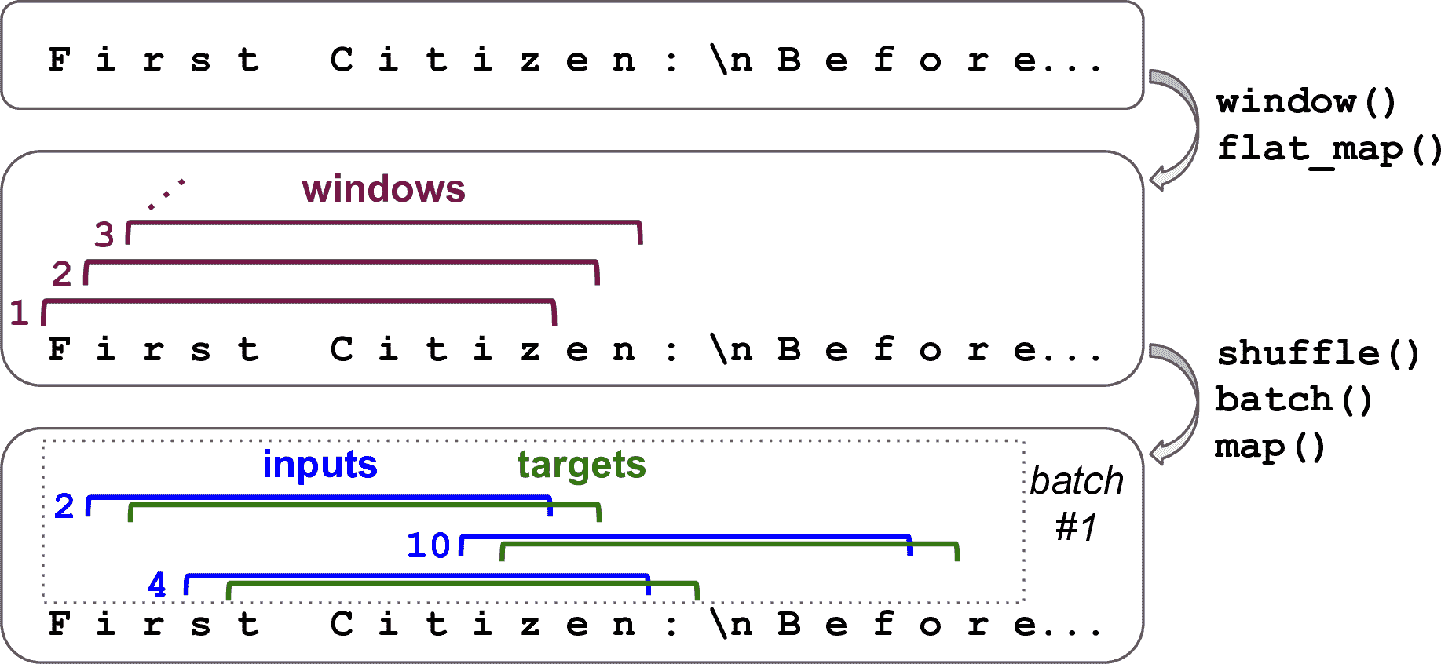

In [10]:
from IPython import display
display.Image("https://hands1ml.apachecn.org/img/847ef99a515939c6266e9a184ac7e061.png",width=640)

In [11]:
#独热编码输入字符，再预提取
max_id=39
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1) 


## 搭建并训练 Char-RNN 模型

In [ ]:
#每个单元对输入（dropout）和隐藏态（recurrent_dropout）的丢弃率是 20%
#输出层是一个时间分布的紧密层，有 39 个单元（max_id）

model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam")
history = model.fit(dataset, epochs=20)

Epoch 1/20
   3353/Unknown - 622s 184ms/step - loss: 1.7559